# Analyzing Data and Interpreting Images with OpenAI's o1 Reasoning Model vs. GPT

## Introduction
OpenAI's o1 reasoning model is designed for complex problem-solving, data analysis, and image interpretation by simulating a multi-step thought process before generating responses. Unlike traditional GPT models, which produce output in a single pass, reasoning models use internal **reasoning tokens** to explore multiple approaches before finalizing an answer.
<p align="center">
    <img src="https://cdn.openai.com/API/images/guides/reasoning_tokens.png" alt="Reasoning Tokens" width="600">
</p>  

*Source: [OpenAI Reasoning Models Guide](https://platform.openai.com/docs/guides/reasoning)*

**Key Differences: o1 Reasoning Model vs. GPT**
- Multi-step reasoning: o1 evaluates different solutions before selecting the best response.
- Deeper analytical capabilities: Optimized for complex data interpretation tasks.
- Context-aware image analysis: Provides more structured and insightful image descriptions.
- Reasoning Effort Control: Users can adjust the depth of reasoning (`low`, `medium`, `high`).


For more details, refer to the [OpenAI Reasoning Models Guide](https://platform.openai.com/docs/guides/reasoning).


## Purchase and Store API Key

You need to **purchase** your [OpenAI](https://openai.com/) API key and store it securely, such as in **AWS Secrets Manager**.

- **Key Name:** `api_key`  
- **Key Value:** `<your OpenAI API key>`  
- **Secret Name:** `openai`  

## Install Python Libraries

- **openai**: Used to call `o1` and `GPT` models for data analysis and image interpretation.

In [1]:
pip install openai -q

Note: you may need to restart the kernel to use updated packages.


## Import Required Libraries

The following libraries are used in this notebook:

- **boto3**: AWS SDK for Python, used to interact with AWS services.
- **json**: Standard Python library for handling JSON data.
- **IPython.display**: Provides tools to display images, Markdown content, and other rich media in Jupyter Notebook.
- **openai**: Used to call `o1` and `GPT` models for data analysis and image interpretation.
- **pandas**: A powerful library for data manipulation and analysis.
- **pprint**: Pretty prints data structures for better readability.

In [2]:
import boto3
import json
from IPython.display import display, Image, Markdown
from openai import OpenAI
import pandas as pd
from pprint import pprint

## Retrieve API Keys Securely from AWS Secrets Manager

The following function, `get_secret()`, retrieves a secret from **AWS Secrets Manager**. This is a secure way to store and access sensitive credentials, such as API keys, without hardcoding them into the script

In [3]:
def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

## Initialize OpenAI Client

The following code initializes the OpenAI client using a securely stored API key retrieved from AWS Secrets Manager.

In [4]:
client = OpenAI(api_key= get_secret('openai')['api_key'])

## Load and Analyze the Diamonds Dataset

This notebook uses the **diamonds dataset ([diamonds.csv](https://github.com/lbsocial/data-analysis-with-generative-ai/blob/main/diamonds.csv))**, which contains detailed attributes of diamonds, including weight, color, clarity, and price.

One interesting pattern in the dataset is that **diamonds with "IF" (Internally Flawless) clarity tend to have the lowest average price** compared to other clarity grades. This observation is counterintuitive, as one might expect the highest-clarity diamonds to be the most expensive.

In [5]:
df = pd.read_csv('diamonds.csv')
data_json = df.to_json(orient="records")
df.head()

,IDNO,WEIGHT,COLOR,CLARITY,RATER,PRICE
0,1,0.30,D,VS2,GIA,1302
1,2,0.30,E,VS1,GIA,1510
2,3,0.30,G,VVS1,GIA,1510
3,4,0.30,G,VS1,GIA,1260
4,5,0.31,D,VS1,GIA,1641


## Generate Data Analysis Prompt for OpenAI Model

To investigate why diamonds with **IF (Internally Flawless) clarity** have the **lowest average price**, we generate a structured prompt for the OpenAI model. The model will analyze the dataset and generate insights, including **Python code for visualizations**.


In [6]:
data_prompt = f"Analyze the provided data and determine why diamonds with IF clarity have the lowest average price. Provide Python-generated charts to support your conclusion. Data: {data_json}"
# print(prompt)

## Define a Function to Get Assistance from OpenAI GPT-4o

The following function, `openai_gpt_help()`, sends a prompt to OpenAI's **GPT-4o model** and returns a response. It also prints the number of tokens used in the request.

In [7]:
def openai_gpt_help(prompt):
    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model='gpt-4o',
        messages=messages,
        temperature = 0
    )
    token_usage = response.usage
    
    pprint(f"Tokens used: {token_usage}")

    return response.choices[0].message.content

In [8]:
gpt_result = openai_gpt_help(prompt=data_prompt)

('Tokens used: CompletionUsage(completion_tokens=805, prompt_tokens=10574, '
 'total_tokens=11379, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, '
 'cached_tokens=10496))')


In [9]:
display(Markdown(gpt_result))

To analyze why diamonds with IF (Internally Flawless) clarity have the lowest average price, we need to examine the dataset and consider various factors that could influence diamond pricing, such as weight, color, and the rating agency. Let's start by loading the data into a pandas DataFrame and then perform some exploratory data analysis (EDA) to understand the distribution of prices based on clarity and other attributes.

Here's a step-by-step analysis using Python:

```python
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data into a DataFrame
data = [
    {"IDNO": 1, "WEIGHT": 0.3, "COLOR": "D", "CLARITY": "VS2", "RATER": "GIA", "PRICE": 1302},
    {"IDNO": 2, "WEIGHT": 0.3, "COLOR": "E", "CLARITY": "VS1", "RATER": "GIA", "PRICE": 1510},
    # ... (rest of the data)
    {"IDNO": 308, "WEIGHT": 1.09, "COLOR": "I", "CLARITY": "VVS2", "RATER": "HRD", "PRICE": 9107}
]

df = pd.DataFrame(data)

# Calculate average price by clarity
avg_price_by_clarity = df.groupby('CLARITY')['PRICE'].mean().sort_values()

# Plot average price by clarity
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_price_by_clarity.index, y=avg_price_by_clarity.values)
plt.title('Average Price by Clarity')
plt.xlabel('Clarity')
plt.ylabel('Average Price')
plt.show()

# Check the distribution of weights for IF clarity diamonds
if_clarity = df[df['CLARITY'] == 'IF']
plt.figure(figsize=(10, 6))
sns.histplot(if_clarity['WEIGHT'], bins=10, kde=True)
plt.title('Weight Distribution for IF Clarity Diamonds')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.show()

# Check the distribution of colors for IF clarity diamonds
plt.figure(figsize=(10, 6))
sns.countplot(x='COLOR', data=if_clarity)
plt.title('Color Distribution for IF Clarity Diamonds')
plt.xlabel('Color')
plt.ylabel('Count')
plt.show()

# Check the distribution of raters for IF clarity diamonds
plt.figure(figsize=(10, 6))
sns.countplot(x='RATER', data=if_clarity)
plt.title('Rater Distribution for IF Clarity Diamonds')
plt.xlabel('Rater')
plt.ylabel('Count')
plt.show()
```

### Analysis:

1. **Average Price by Clarity**: The bar plot shows the average price for each clarity category. If IF clarity diamonds have the lowest average price, it could be due to other factors like weight, color, or the rating agency.

2. **Weight Distribution**: The histogram for IF clarity diamonds shows the distribution of weights. If IF diamonds tend to have lower weights, this could contribute to their lower average price, as weight is a significant factor in diamond pricing.

3. **Color Distribution**: The count plot for colors of IF clarity diamonds shows which colors are more prevalent. If IF diamonds are predominantly of lower color grades (e.g., H, I), this could also lower their average price.

4. **Rater Distribution**: The count plot for raters of IF clarity diamonds shows which rating agencies are more common. Different agencies might have different grading standards, affecting the price.

### Conclusion:

The lower average price of IF clarity diamonds could be due to a combination of factors such as lower average weight, lower color grades, or the influence of certain rating agencies. By examining these distributions, we can better understand the pricing dynamics for IF clarity diamonds.

## Define a Function to Get Assistance from OpenAI o1 Model  

The following function, `openai_o_help()`, sends a prompt to OpenAI's **o1 reasoning model** and returns a response.  

### Key Differences Between o1 and GPT Models:
- **Reasoning Effort**: The o1 model allows users to control reasoning depth using `reasoning_effort` (`low`, `medium`, `high`).  
- **No Temperature Parameter**: Unlike GPT models, **o1 does not support `temperature`**.  
- **Developer Messages Replace System Messages**:  
  - Starting with `o1-2024-12-17`, **developer messages** replace **system messages** to align with chain-of-command behavior.  

### Best Practices for Prompting o1  
- **Keep prompts simple and direct.**  
- **Avoid chain-of-thought prompts.** o1 reasons internally, so step-by-step instructions aren't needed.  
- **Use delimiters for clarity.** Use Markdown, XML tags, or section titles.  
- **Try zero-shot first.** If needed, add few-shot examples that closely match your goal.  
- **Be explicit.** Clearly define success criteria and constraints.  
- **Markdown is disabled by default.** To enable, start with `"Formatting re-enabled"`.  

Source: [OpenAI Reasoning Models Best Practices Guide](https://platform.openai.com/docs/guides/reasoning-best-practices).  


In [10]:
def openai_o_help(prompt):
    messages = [ {"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model='o1',
        reasoning_effort="high", # low, medium or high
        messages=messages,

    )
    token_usage = response.usage
    
    pprint(f"Tokens used: {token_usage}")

    return response.choices[0].message.content

In [11]:
o1_result = openai_o_help(prompt=data_prompt)

('Tokens used: CompletionUsage(completion_tokens=3574, prompt_tokens=10573, '
 'total_tokens=14147, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=2624, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, '
 'cached_tokens=10496))')


In [12]:
print(o1_result)

Below is an illustrative example in Python showing how one can arrive at the conclusion that the “IF” (Internally Flawless) diamonds in this dataset have a lower overall average price because they tend to be disproportionately small (low carat weight) compared to diamonds of other clarities. Despite “IF” generally commanding a premium per carat, the heavy skew toward lower-carat stones brings down the absolute (total) price average.

--------------------------------------------------------------------------------
1) Read in the data and create a pandas DataFrame
--------------------------------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Put your JSON data (list of dicts) into a DataFrame
data = [
    {"IDNO":1,"WEIGHT":0.3,"COLOR":"D","CLARITY":"VS2","RATER":"GIA","PRICE":1302},
    {"IDNO":2,"WEIGHT":0.3,"COLOR":"E","CLARITY":"VS1","RATER":"GIA","PRICE":1510},
    {"IDNO":3,"WEIGHT":0.3,"COLOR":"G","CLA

## Load and Display an Image from a URL

This code retrieves an image from a specified URL and displays it using the **PIL (Pillow) library**.

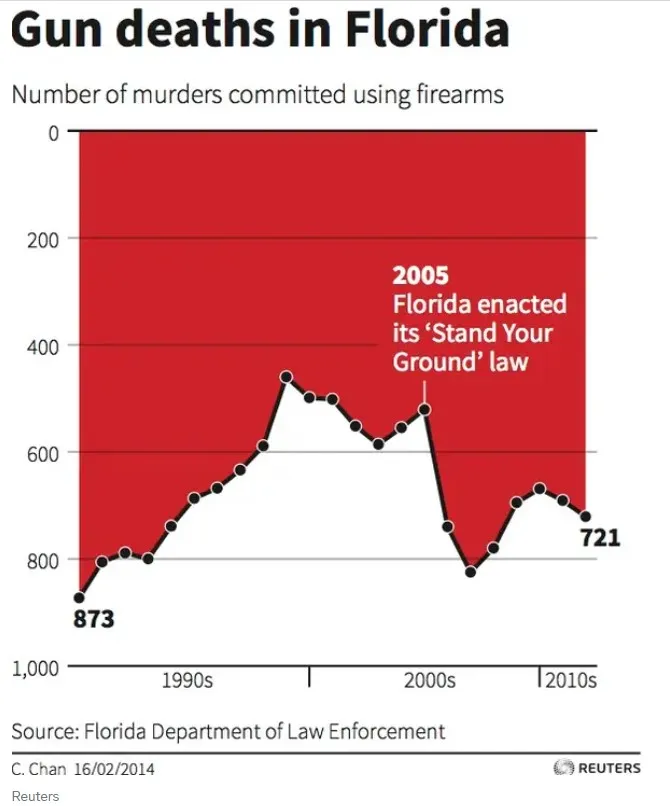

In [13]:
from PIL import Image
import requests
from io import BytesIO

image_url = "https://miro.medium.com/v2/resize:fit:4800/format:webp/1*VPRpf0YnchAwN0mjeAz4pA.jpeg"
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img.show()

## Create an Image Analysis Prompt

The following code constructs a **structured prompt** for analyzing an image. It sends both **text input** and an **image URL** to an AI model for interpretation.


In [14]:
image_prompt = [
                    {"type": "text", "text": 'what is wrong with this image?'},
                    {"type": "image_url", "image_url": {
                        "url": image_url}
                    }
                ]

In [15]:
gpt_result = openai_gpt_help(prompt=image_prompt)

('Tokens used: CompletionUsage(completion_tokens=48, prompt_tokens=779, '
 'total_tokens=827, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))')


In [16]:
display(Markdown(gpt_result))

The image has a misleading y-axis. The axis starts at 600 instead of 0, which exaggerates the visual difference in the number of gun deaths over time. This can make the changes appear more dramatic than they actually are.

In [17]:
o1_result = openai_o_help(prompt=image_prompt)

('Tokens used: CompletionUsage(completion_tokens=2250, prompt_tokens=688, '
 'total_tokens=2938, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=2112, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))')


In [18]:
display(Markdown(o1_result))

A glance at the vertical scale gives it away: the chart has effectively been flipped so that “0” is at the top and “1,000” is at the bottom. In other words, the y‐axis is running **downwards** instead of upwards. That reversed axis distorts how the trend appears and makes the modest difference in the murder totals look far more dramatic than it really is.

## References  
- **OpenAI Reasoning Models Guide**: [OpenAI](https://platform.openai.com/docs/guides/reasoning)  
- **OpenAI Reasoning Models Best Practices Guide**: [OpenAI](https://platform.openai.com/docs/guides/reasoning-best-practices)  
- **Colin Jarvis. “Reasoning with O1.” DeepLearning.AI.** Accessed February 14, 2025. [DeepLearning.AI](https://www.deeplearning.ai/short-courses/reasoning-with-o1/)  